In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import scipy

In [2]:
V_na_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/na_true/gru_l20_h40_0.2ms_test_V.npy")
V_nona_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_true/gru_l20_h40_0.2ms_test_V.npy")
V_comb_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V.npy")
V_whole_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy")
V_ap_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/ap_true/gru_l20_h40_0.2ms_test_V.npy")
V_interact_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V_dend_interact.npy")
V_joint_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V_test_joint_output.npz")["test"]
V_dual_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V.npy")
V_dual_joint_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_joint.npy")
V_dual_interact_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_dend_interact.npy")

spk = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].reshape(20,50000)

V_na_true_next = np.zeros((20,50000))
V_nona_true_next = np.zeros((20,50000))
V_comb_pred_next = np.zeros((20,50000))
V_whole_pred_next = np.zeros((20,50000))
V_ap_true_next = np.zeros((20,50000))
V_joint_pred_next = np.zeros((20,50000))
V_interact_pred_next = np.zeros((20,50000))
V_dual_pred_next = np.zeros((20,50000))
V_dual_joint_pred_next = np.zeros((20,50000))
V_dual_interact_pred_next = np.zeros((20,50000))

V_na_true_next[:,:-1] = V_na_true[:,1:]
V_nona_true_next[:,:-1] = V_nona_true[:,1:]
V_comb_pred_next[:,:-1] = V_comb_pred[:,1:]
V_whole_pred_next[:,:-1] = V_whole_pred[:,1:]
V_ap_true_next[:,:-1] = V_ap_true[:,1:]
V_joint_pred_next[:,:-1] = V_joint_pred[:,1:]
V_interact_pred_next[:,:-1] = V_interact_pred[:,1:]
V_dual_pred_next[:,:-1] = V_dual_pred[:,1:]
V_dual_joint_pred_next[:,:-1] = V_dual_joint_pred[:,1:]
V_dual_interact_pred_next[:,:-1] = V_dual_interact_pred[:,1:]

In [3]:
thresh_list = np.arange(10,20)
bin_size = 4 * 5
na_true_pr = np.empty((thresh_list.shape[0],20, 2))
nona_true_pr = np.empty((thresh_list.shape[0],20, 2))
comb_pred_pr = np.empty((thresh_list.shape[0],20, 2))
whole_pred_pr = np.empty((thresh_list.shape[0],20, 2))
ap_true_pr = np.empty((thresh_list.shape[0],20, 2))
joint_pred_pr = np.empty((thresh_list.shape[0],20, 2))
interact_pred_pr = np.empty((thresh_list.shape[0],20, 2))
dual_pred_pr = np.empty((thresh_list.shape[0],20, 2))
dual_joint_pred_pr = np.empty((thresh_list.shape[0],20, 2))
dual_interact_pred_pr = np.empty((thresh_list.shape[0],20, 2))

for n in tnrange(10):
    if n == 0:
        V = V_na_true
        V_next = V_na_true_next
    elif n == 1:
        V = V_nona_true
        V_next = V_nona_true_next
    elif n == 2:
        V = V_comb_pred
        V_next = V_comb_pred_next
    elif n == 3:
        V = V_whole_pred
        V_next = V_whole_pred_next
    elif n == 4:
        V = V_ap_true
        V_next = V_ap_true_next
    elif n == 5:
        V = V_joint_pred
        V_next = V_joint_pred_next
    elif n == 6:
        V = V_interact_pred
        V_next = V_interact_pred_next
    elif n == 7:
        V = V_dual_pred
        V_next = V_dual_pred_next
    elif n == 8:
        V = V_dual_joint_pred
        V_next = V_dual_joint_pred_next
    elif n == 9:
        V = V_dual_interact_pred
        V_next = V_dual_interact_pred_next
        
    for i in range(thresh_list.shape[0]):
        thresh = thresh_list[i]
        
        for j in range(20):
            S = np.zeros((50000))
            idx = np.where((V[j] < thresh) & (V_next[j] >= thresh))[0]
            S[idx] = 1

            prob_bin = scipy.ndimage.convolve1d(S, np.ones((bin_size)), 0)
            prob_bin = prob_bin[bin_size-1:-bin_size+1]
            prob_bin[prob_bin>0] = 1
            spk_bin = scipy.ndimage.convolve1d(spk[j], np.ones((bin_size)), 0)
            spk_bin = spk_bin[bin_size-1:-bin_size+1]
            spk_bin[spk_bin>0] = 1

            tp = np.where((prob_bin == 1) & (spk_bin == 1))[0].size
            fp = np.where((prob_bin == 1) & (spk_bin == 0))[0].size
            tn = np.where((prob_bin == 0) & (spk_bin == 0))[0].size
            fn = np.where((prob_bin == 0) & (spk_bin == 1))[0].size
        
            prec = tp / (tp + fp)
            rec = tp / (tp + fn)
        
            if n == 0:
                na_true_pr[i,j,0] = prec
                na_true_pr[i,j,1] = rec
            elif n == 1:
                nona_true_pr[i,j,0] = prec
                nona_true_pr[i,j,1] = rec
            elif n == 2:
                comb_pred_pr[i,j,0] = prec
                comb_pred_pr[i,j,1] = rec
            elif n == 3:
                whole_pred_pr[i,j,0] = prec
                whole_pred_pr[i,j,1] = rec
            elif n == 4:
                ap_true_pr[i,j,0] = prec
                ap_true_pr[i,j,1] = rec
            elif n == 5:
                joint_pred_pr[i,j,0] = prec
                joint_pred_pr[i,j,1] = rec
            elif n == 6:
                interact_pred_pr[i,j,0] = prec
                interact_pred_pr[i,j,1] = rec
            elif n == 7:
                dual_pred_pr[i,j,0] = prec
                dual_pred_pr[i,j,1] = rec
            elif n == 8:
                dual_joint_pred_pr[i,j,0] = prec
                dual_joint_pred_pr[i,j,1] = rec
            elif n == 9:
                dual_interact_pred_pr[i,j,0] = prec
                dual_interact_pred_pr[i,j,1] = rec

<ipython-input-3-94037aa6ef4f>:14: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n in tnrange(10):


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plt.scatter(joint_pred_pr[6,:,1], joint_pred_pr[6,:,0])

In [23]:
print(thresh_list[6])

16


In [4]:
print("AP True", np.mean(ap_true_pr[6,:,1]), np.mean(ap_true_pr[6,:,0]),
      np.std(ap_true_pr[6,:,1]), np.std(ap_true_pr[6,:,0]))
print("Na True", np.mean(na_true_pr[6,:,1]), np.mean(na_true_pr[6,:,0]),
      np.std(na_true_pr[6,:,1]), np.std(na_true_pr[6,:,0]))
print("No Na True", np.mean(nona_true_pr[6,:,1]), np.mean(nona_true_pr[6,:,0]),
      np.std(nona_true_pr[6,:,1]), np.std(nona_true_pr[6,:,0]))
print("Comb Pred", np.mean(comb_pred_pr[6,:,1]), np.mean(comb_pred_pr[6,:,0]),
      np.std(comb_pred_pr[6,:,1]), np.std(comb_pred_pr[6,:,0]))
print("Whole Pred", np.mean(whole_pred_pr[6,:,1]), np.mean(whole_pred_pr[6,:,0]),
      np.std(whole_pred_pr[6,:,1]), np.std(whole_pred_pr[6,:,0]))
print("Joint Pred", np.mean(joint_pred_pr[6,:,1]), np.mean(joint_pred_pr[6,:,0]),
      np.std(joint_pred_pr[6,:,1]), np.std(joint_pred_pr[6,:,0]))
print("Interact Pred", np.mean(interact_pred_pr[6,:,1]), np.mean(interact_pred_pr[6,:,0]),
      np.std(interact_pred_pr[6,:,1]), np.std(interact_pred_pr[6,:,0]))
print("Dual Pred", np.mean(dual_pred_pr[6,:,1]), np.mean(dual_pred_pr[6,:,0]),
      np.std(dual_pred_pr[6,:,1]), np.std(dual_pred_pr[6,:,0]))
print("Dual Joint Pred", np.mean(dual_joint_pred_pr[6,:,1]), np.mean(dual_joint_pred_pr[6,:,0]),
      np.std(dual_joint_pred_pr[6,:,1]), np.std(dual_joint_pred_pr[6,:,0]))
print("Dual Interact Pred", np.mean(dual_interact_pred_pr[6,:,1]), np.mean(dual_interact_pred_pr[6,:,0]),
      np.std(dual_interact_pred_pr[6,:,1]), np.std(dual_interact_pred_pr[6,:,0]))

AP True 0.9156042360417361 0.9156042360417361 0.0096387818643847 0.0096387818643847
Na True 0.8143590159840158 0.8386963383838383 0.06843242335670274 0.06615087825324792
No Na True 0.34974221611721606 0.6056746031746031 0.0940514647548976 0.11510389858903808
Comb Pred 0.47738816738816736 0.5966674783549784 0.13561578097444554 0.12230436902117042
Whole Pred 0.34591172716172713 0.5486351367828324 0.11432601029228029 0.13394760326878388
Joint Pred 0.571482357919858 0.5902901959151958 0.11677126832211036 0.12180384937549094
Interact Pred 0.476412191974692 0.613834595959596 0.12597806436497425 0.1120788110075319
Dual Pred 0.5339070096570098 0.6027269119769121 0.11504890323598695 0.12183115172010493
Dual Joint Pred 0.5353483738483739 0.608891206016206 0.12105461715699198 0.12160309192516046
Dual Interact Pred 0.5319628704628704 0.597951479076479 0.11431395145981849 0.13002215512915635


In [6]:
V_ap_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/ap_true/gru_l20_h40_0.2ms_test_V.npy")
V_na_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/na_true/gru_l20_h40_0.2ms_test_V.npy")
V_nona_true = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_true/gru_l20_h40_0.2ms_test_V.npy")
V_comb_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V.npy")
V_whole_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy")
V_interact_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V_dend_interact.npy")
V_joint_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_V_test_joint_output.npz")["test"]
V_dual_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V.npy")
V_dual_joint_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_joint.npy")
V_dual_interact_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_dual_l20_h40_0.2ms_test_V_dend_interact.npy")

spk = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].reshape(20,50000)

V_ap_true_next = np.zeros((20,50000))
V_na_true_next = np.zeros((20,50000))
V_nona_true_next = np.zeros((20,50000))
V_comb_pred_next = np.zeros((20,50000))
V_whole_pred_next = np.zeros((20,50000))
V_joint_pred_next = np.zeros((20,50000))
V_interact_pred_next = np.zeros((20,50000))
V_dual_pred_next = np.zeros((20,50000))
V_dual_joint_pred_next = np.zeros((20,50000))
V_dual_interact_pred_next = np.zeros((20,50000))

V_na_true_next[:,:-1] = V_na_true[:,1:]
V_nona_true_next[:,:-1] = V_nona_true[:,1:]
V_comb_pred_next[:,:-1] = V_comb_pred[:,1:]
V_whole_pred_next[:,:-1] = V_whole_pred[:,1:]
V_ap_true_next[:,:-1] = V_ap_true[:,1:]
V_joint_pred_next[:,:-1] = V_joint_pred[:,1:]
V_interact_pred_next[:,:-1] = V_interact_pred[:,1:]
V_dual_pred_next[:,:-1] = V_dual_pred[:,1:]
V_dual_joint_pred_next[:,:-1] = V_dual_joint_pred[:,1:]
V_dual_interact_pred_next[:,:-1] = V_dual_interact_pred[:,1:]

ap_true_coinc = np.zeros((20,))
na_true_coinc = np.zeros((20,))
nona_true_coinc = np.zeros((20,))
comb_pred_coinc = np.zeros((20,))
whole_pred_coinc = np.zeros((20,))
joint_pred_coinc = np.zeros((20,))
interact_pred_coinc = np.zeros((20,))
dual_pred_coinc = np.zeros((20,))
dual_joint_pred_coinc = np.zeros((20,))
dual_interact_pred_coinc = np.zeros((20,))

thresh = 15
window = 4 * 5
T = 50000

for n in tnrange(10):
    if n == 0:
        V = V_ap_true
        V_next = V_ap_true_next
    elif n == 1:
        V = V_na_true
        V_next = V_na_true_next
    elif n == 2:
        V = V_nona_true
        V_next = V_nona_true_next
    elif n == 3:
        V = V_comb_pred
        V_next = V_comb_pred_next
    elif n == 4:
        V = V_whole_pred
        V_next = V_whole_pred_next
    elif n == 5:
        V = V_joint_pred
        V_next = V_joint_pred_next
    elif n == 6:
        V = V_interact_pred
        V_next = V_interact_pred_next
    elif n == 7:
        V = V_dual_pred
        V_next = V_dual_pred_next
    elif n == 8:
        V = V_dual_joint_pred
        V_next = V_dual_joint_pred_next
    elif n == 9:
        V = V_dual_interact_pred
        V_next = V_dual_interact_pred_next
    
    S = np.zeros((20,50000))
    
    for i in range(20):
        idx = np.where((V[i] < thresh) & (V_next[i] >= thresh))[0]
        S[i,idx] = 1
    
        #pred_bin = scipy.ndimage.convolve1d(S.reshape(20,50000), np.ones((window)), 1)
        #pred_bin = pred_bin[:,window-1:-window+1]
        #pred_bin[pred_bin>0] = 1
        #spk_bin = scipy.ndimage.convolve1d(spk.reshape(20,50000), np.ones((window)), 1)
        #spk_bin = spk_bin[:,window-1:-window+1]
        #spk_bin[spk_bin>0] = 1
        
        pred_idx = np.where(S[i] > 0)[0]
        spk_idx = np.where(spk[i] > 0)[0]
        
        N_coinc = 0
        for a in pred_idx:
            for b in spk_idx:
                if np.abs(a-b) < window:
                    N_coinc += 1

        N_n = int(np.sum(spk[i]))
        N_m = int(np.sum(S[i]))
        #N_pois = 2 * window * N_n * N_m / T
        #N_nm = np.where((pred_bin[i] == 1) & (spk_bin[i] == 1))[0].size
        #coinc = (N_nm - N_pois) / (0.5*(1-N_pois/N_n)*(N_n+N_m))
        
        #N_coinc = np.where((pred_bin[i] == 1) & (spk_bin[i] == 1))[0].size
        N_pois = 2 * window * N_n * N_m / T
        N = 1 - 2*N_m/T*window
        coinc = (N_coinc - N_pois)/(0.5*(N_n+N_m)*N)
        
        #N_pois_true = 2 * window * N_n * N_n / T
        #N_true = 1 - 2*N_n/T*window
        #true_coinc = (N_n - N_pois_true) / (0.5*(N_n+N_n)*N_true)
        
        #if coinc > 1:
            #print(coinc, N_n, N_m, N_coinc, N_pois, N)
            
        #if N_n < N_coinc:
            #print(coinc, N_n, N_m, N_coinc, N_pois, N)
        
        if n == 0:
            ap_true_coinc[i] = coinc / 1
        elif n == 1:
            na_true_coinc[i] = coinc / 1
        elif n == 2:
            nona_true_coinc[i] = coinc / 1
        elif n == 3:
            comb_pred_coinc[i] = coinc / 1
        elif n == 4:
            whole_pred_coinc[i] = coinc / 1
        elif n == 5:
            joint_pred_coinc[i] = coinc / 1
        elif n == 6:
            interact_pred_coinc[i] = coinc / 1
        elif n == 7:
            dual_pred_coinc[i] = coinc / 1
        elif n == 8:
            dual_joint_pred_coinc[i] = coinc / 1
        elif n == 9:
            dual_interact_pred_coinc[i] = coinc / 1

<ipython-input-6-7232c1a9b8c7>:51: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for n in tnrange(10):


  0%|          | 0/10 [00:00<?, ?it/s]

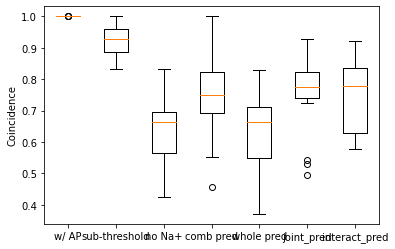

In [4]:
coinc_all = np.zeros((20,7))
coinc_all[:,0] = ap_true_coinc
coinc_all[:,1] = na_true_coinc
coinc_all[:,2] = nona_true_coinc
coinc_all[:,3] = comb_pred_coinc
coinc_all[:,4] = whole_pred_coinc
coinc_all[:,5] = joint_pred_coinc
coinc_all[:,6] = interact_pred_coinc

labels = ["w/ AP", "sub-threshold", "no Na+", "comb pred",  "whole pred", "joint_pred", "interact_pred"]

plt.boxplot(coinc_all)
plt.xticks(np.arange(1,8), labels)
plt.ylabel("Coincidence")
plt.show()

In [7]:
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/coinc_4ms_15v.npy", ap_true_coinc)
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/coinc_4ms_15v.npy", na_true_coinc)
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/coinc_4ms_15v.npy", nona_true_coinc)
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/coinc_4ms_15v.npy", comb_pred_coinc)
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/coinc_4ms_15v.npy", whole_pred_coinc)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/joint_coinc_4ms_15v.npy", joint_pred_coinc)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/interact_coinc_4ms_15v.npy", interact_pred_coinc)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/dual_coinc_4ms_15v.npy", dual_pred_coinc)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/dual_joint_coinc_4ms_15v.npy", dual_joint_pred_coinc)
#np.save("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/dual_interact_coinc_4ms_15v.npy", dual_interact_pred_coinc)

In [3]:
ms_list = [1,2,5,10]
auc_array = np.zeros((4,13,20))

for i in tnrange(4):
    length = int(50000/ms_list[i]/5)
    ap_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/ap_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    whole_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    diff_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/diff_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    comb_pred_late_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/comb_pred_late/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_nona_pred_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_nona_pred/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_pred_nona_true_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_pred_nona_true/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    na_true_noise_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/na_true_noise/gru_l20_h40_"+str(ms_list[i])+"ms_test.npy").flatten()
    
    spk_all = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/spike_train_"+str(ms_list[i])+"ms.npy")[980*length:].flatten()
    
    for j in range(20):
        ap_true = ap_true_all[j*length:(j+1)*length]
        na_true = na_true_all[j*length:(j+1)*length]
        nona_true = nona_true_all[j*length:(j+1)*length]
        comb_pred = comb_pred_all[j*length:(j+1)*length]
        whole_pred = whole_pred_all[j*length:(j+1)*length]
        diff_true = diff_true_all[j*length:(j+1)*length]
        diff_pred = diff_pred_all[j*length:(j+1)*length]
        nona_pred = nona_pred_all[j*length:(j+1)*length]
        na_true_late = na_true_late_all[j*length:(j+1)*length]
        comb_pred_late = comb_pred_late_all[j*length:(j+1)*length]
        na_true_nona_pred = na_true_nona_pred_all[j*length:(j+1)*length]
        na_pred_nona_true = na_pred_nona_true_all[j*length:(j+1)*length]
        na_true_noise = na_true_noise_all[j*length:(j+1)*length]
        spk = spk_all[j*length:(j+1)*length]
        
        prec_comb_pred, rec_comb_pred, _ = precision_recall_curve(spk, comb_pred)
        prec_whole_pred, rec_whole_pred, _ = precision_recall_curve(spk, whole_pred)
        prec_ap_true, rec_ap_true, _ = precision_recall_curve(spk, ap_true)
        prec_na_true, rec_na_true, _ = precision_recall_curve(spk, na_true)
        prec_nona_true, rec_nona_true, _ = precision_recall_curve(spk, nona_true)
        prec_diff_true, rec_diff_true, _ = precision_recall_curve(spk, diff_true)
        prec_diff_pred, rec_diff_pred, _ = precision_recall_curve(spk, diff_pred)
        prec_nona_pred, rec_nona_pred, _ = precision_recall_curve(spk, nona_pred)
        prec_na_true_late, rec_na_true_late, _ = precision_recall_curve(spk, na_true_late)
        prec_comb_pred_late, rec_comb_pred_late, _ = precision_recall_curve(spk, comb_pred_late)
        prec_na_true_nona_pred, rec_na_true_nona_pred, _ = precision_recall_curve(spk, na_true_nona_pred)
        prec_na_pred_nona_true, rec_na_pred_nona_true, _ = precision_recall_curve(spk, na_pred_nona_true)
        prec_na_true_noise, rec_na_true_noise, _ = precision_recall_curve(spk, na_true_noise)

        prarea_comb_pred = metrics.auc(rec_comb_pred, prec_comb_pred)
        prarea_whole_pred = metrics.auc(rec_whole_pred, prec_whole_pred)
        prarea_ap_true = metrics.auc(rec_ap_true, prec_ap_true)
        prarea_na_true = metrics.auc(rec_na_true, prec_na_true)
        prarea_nona_true = metrics.auc(rec_nona_true, prec_nona_true)
        prarea_diff_true = metrics.auc(rec_diff_true, prec_diff_true)
        prarea_diff_pred = metrics.auc(rec_diff_pred, prec_diff_pred)
        prarea_nona_pred = metrics.auc(rec_nona_pred, prec_nona_pred)
        prarea_na_true_late = metrics.auc(rec_na_true_late, prec_na_true_late)
        prarea_comb_pred_late = metrics.auc(rec_comb_pred_late, prec_comb_pred_late)
        prarea_na_true_nona_pred = metrics.auc(rec_na_true_nona_pred, prec_na_true_nona_pred)
        prarea_na_pred_nona_true = metrics.auc(rec_na_pred_nona_true, prec_na_pred_nona_true)
        prarea_na_true_noise = metrics.auc(rec_na_true_noise, prec_na_true_noise)
        
        auc_array[i,0,j] = prarea_ap_true
        auc_array[i,1,j] = prarea_na_true
        auc_array[i,2,j] = prarea_nona_true
        auc_array[i,3,j] = prarea_comb_pred
        auc_array[i,4,j] = prarea_whole_pred
        auc_array[i,5,j] = prarea_diff_true
        auc_array[i,6,j] = prarea_diff_pred
        auc_array[i,7,j] = prarea_nona_pred
        auc_array[i,8,j] = prarea_na_true_late
        auc_array[i,9,j] = prarea_comb_pred_late
        auc_array[i,10,j] = prarea_na_true_nona_pred
        auc_array[i,11,j] = prarea_na_pred_nona_true
        auc_array[i,12,j] = prarea_na_true_noise

<ipython-input-3-b0887cb02ca1>:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(4):


  0%|          | 0/4 [00:00<?, ?it/s]

<ipython-input-5-90c9aa75c4ff>:80: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


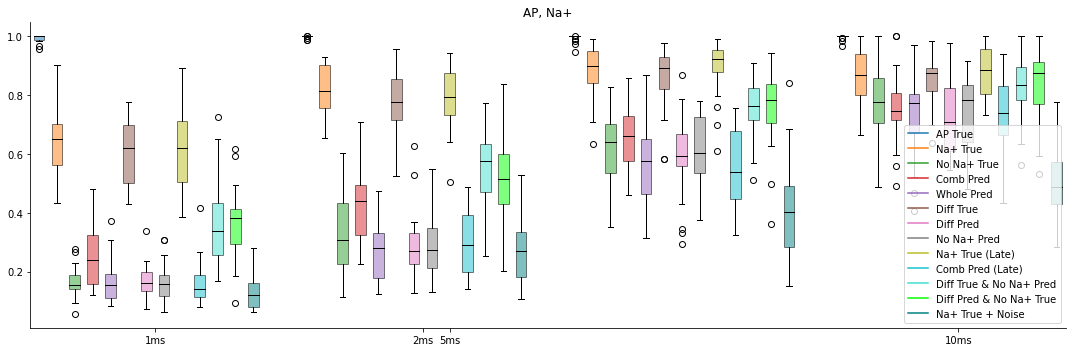

In [5]:
fig = plt.figure(constrained_layout=True, figsize = (15,5))
gs = fig.add_gridspec(1,1, wspace=0, hspace=0)
ax = fig.add_subplot(gs[0,0])

colors = ["tab:blue","tab:orange","tab:green",
         "tab:red","tab:purple","tab:brown","tab:pink","tab:gray",
         "tab:olive","tab:cyan","turquoise","lime", "teal"]

# first boxplot pair
bp = ax.boxplot(auc_array[0].T, positions = np.arange(0,13,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[1].T, positions = np.arange(15,28,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[2].T, positions = np.arange(30,43,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
# first boxplot pair
bp = ax.boxplot(auc_array[3].T, positions = np.arange(45,58,1), widths = 0.6, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
for patch in bp["medians"]:
    patch.set_color("black")
    
ax.set_xticks([6.5,21.5,23,51.5])
ax.set_xticklabels(["1ms", "2ms", "5ms", "10ms"])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_title("AP, Na+")

h1, = ax.plot(1,1,'tab:blue')
h2, = ax.plot(1,1,'tab:orange')
h3, = ax.plot(1,1,'tab:green')
h4, = ax.plot(1,1,'tab:red')
h5, = ax.plot(1,1,'tab:purple')
h6, = ax.plot(1,1,'tab:brown')
h7, = ax.plot(1,1,'tab:pink')
h8, = ax.plot(1,1,'tab:gray')
h9, = ax.plot(1,1,'tab:olive')
h10, = ax.plot(1,1,'tab:cyan')
h11, = ax.plot(1,1,'turquoise')
h12, = ax.plot(1,1,'lime')
h13, = ax.plot(1,1,'teal')

ax.legend((h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13),('AP True','Na+ True','No Na+ True','Comb Pred',
                                           'Whole Pred', 'Diff True', 'Diff Pred', 'No Na+ Pred',
                                           'Na+ True (Late)', 'Comb Pred (Late)', "Diff True & No Na+ Pred",
                                           "Diff Pred & No Na+ True", "Na+ True + Noise"))
h1.set_visible(False)
h2.set_visible(False)
h3.set_visible(False)
h4.set_visible(False)
h5.set_visible(False)
h6.set_visible(False)
h7.set_visible(False)
h8.set_visible(False)
h9.set_visible(False)
h10.set_visible(False)
h11.set_visible(False)
h11.set_visible(False)
h12.set_visible(False)
h13.set_visible(False)

fig.tight_layout()
plt.show()